# Practical 3: Transfer Learning

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10. 

We will mark your code based on the accuracy of your model. You should try to get **at least 80%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

'2.4.0'

In [ ]:
tf.keras.__version__

'2.4.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

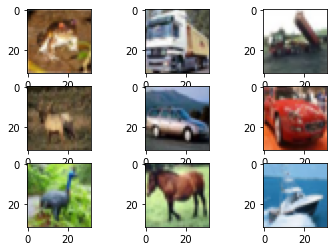

(50000, 32, 32, 3)
(45000, 32, 32, 3)


In [ ]:
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

print(X_train_full.shape)

# ResNet50 preprocess
from keras.applications.resnet50 import preprocess_input
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)

# Converts a class vector (integers) to one-hot encoding matrix
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# Get validation dataset. We take 5 thoudsands images randomly from the training data as the validation data
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

print(X_train.shape)

# Prepare data generator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2, horizontal_flip=True,
                             fill_mode='nearest')
train_data_generator= datagen.flow(X_train, y_train, batch_size=32)

## Build and train the model

Build and train your model. 

In [ ]:
# TODO: load the model you selected

# Loading ResNet50 model. Input shape is set to (224, 224, 3), as we are going to
# resize the cifar10 images
resnet_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
# resnet_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(32, 32, 3), weights='imagenet')

# TODO: Transfer learning - build your own model based on the selected model

# Freeze last main convolutional part of ResNet50
for layer in resnet_model.layers[:resnet_model.layers.index(resnet_model.get_layer('conv5_block1_1_conv'))]:
    layer.trainable=False

# for layer in resnet_model.layers[:resnet_model.layers.index(resnet_model.get_layer('conv3_block3_1_conv'))]:
#     layer.trainable=False

# # Print out which layers are frozen or not
# for i, layer in enumerate(resnet_model.layers):
#     print(i, layer.name, "-", layer.trainable)

# # First approach
# x = resnet_model.get_layer('conv3_block4_out').output
# x = keras.layers.Flatten()(x)
# x = keras.layers.Dropout(0.2)(x)
# x = keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal")(x) # Dense layer 1
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.2)(x)
# x = keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal")(x) # Dense layer 2
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.2)(x)
# x = keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal")(x) # Dense layer 3
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Dropout(0.2)(x)
# output = keras.layers.Dense(units=10, activation='softmax')(x) # Output layer with softmax activation
# model = keras.Model(inputs=resnet_model.input, outputs=output)

# Cifar10 images are going to get resized to shape of imagenet images 
to_res = (224, 224)

# Building the new model
input_layer = keras.layers.Input(shape = (32,32,3))
x = keras.layers.Lambda(lambda image: tf.image.resize(image, to_res))(input_layer) # Input images are resized to different shape
x = resnet_model(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal")(x) # Dense layer 1
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal")(x) # Dense layer 2
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal")(x) # Dense layer 3
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(units=10, activation='softmax')(x) # Output layer with softmax activation
model = keras.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Implementing early stopping and data augmentation
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_data_generator, 
          steps_per_epoch = len(X_train) // 32,
          epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping_cb])

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_22[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# show the structure of your model
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               51380736  
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               204

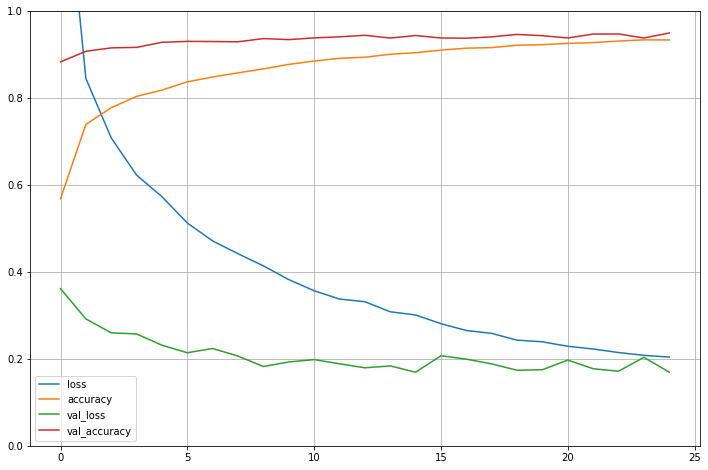

In [ ]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

In [ ]:
model.save('cifar10.h5') 

## Load the model and evaluate it on the test data

In [ ]:
model = keras.models.load_model("cifar10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 31s 96ms/step - loss: 0.1817 - accuracy: 0.9415


[0.18167279660701752, 0.9415000081062317]

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

We chose the ResNet50 model to perform transfer learning. ResNet50 basically consists of 5 main convolutional parts (each part, except for the first one, contains convolutional and identity blocks). While experimenting with ResNet50, we discovered that it is difficult to decide which layers exactly should be reused for our new model. In the end we decided to try out two different approaches.

The first approach was to try bulding a model reusing either the first 3 or the first 4 main convolutional parts of ResNet50. After the reused layers, we added 1, 2 or 3 dense layers with 512 nodes each and dropout regularisation between them. We discovered that a dropout rate of 0.2 is enough, as a higher rate simply decreased accurracy on both the training and validation data (underfitting). While testing out the different hyperparameters, we found out that reusing the first 3 main convolutional parts almost always outperformed reusing the first 4. We fine-tuned some of the layers by unfreezing some of the weights and re-training them on our cifar10 data set. The best-performing model we could obtain reused 3 main convolutional layers of ResNet50, had the last 2 identity blocks of the third main convolutional layer re-trained on the cifar10 data set and used 3 dense layers with 512 nodes each and a dropout rate of 0.2 between them. However, the accuracy which it achieved on the validation set was only around 0.8450 and it needed more than 50 epochs to reach it.

The second approach, which is contained in the code of this notebook, delivered much better results (more than 0.90 accuracy on the validation data only after 2 epochs). For this approach, we reuse all the layers of the ResNet50 model and unfreeze the weights of the last (fifth) main convolutional part. In addition, to make this approach work, we resize the shape of the cifar10 images (32, 32, 3) to the original shape of the imagenet data set images (224, 224, 3). This small adjustment leads to a huge improvement in the achieved accuracy of our model. As in the first approach, we use 3 hidden dense layers with 512 nodes each, after the reused layers of the ResNet50 model. We increase the dropout rate to 0.5 in order to counteract the overfitting, as we unfreeze the whole last main convolutional part of ResNet50. We use the Adam optimiser instead of SGD, as it requires less steps to converge. The learning rate is kept low (at 1e-4) to take advantage of the weights of the pretrained model. The low learning rate could slow down convergence, however we are using Colab's GPU, which significantly decreases runtime. Due to the potential slow convergence, we implement the model with 100 epochs, however counteract this by utilizing early stopping. In addition, we implement data augmentation, which should limit overfitting. The final model achieves 0.9415 accuracy on the test set.

To limit the problem of vanishing/exploding gradients, we use ReLU activation functions for the hidden layers, with a corresponding He initialisation of the weights. To that end, batch normalisation after the activation functions is also utilized.

During this practical, we both gathered hands-on experience with Transfer Learning for the first time. We found out that having GPU ressources at one's disposal for training a large model is essential. Furthermore, we saw that matching the image size to the size of the original input to the pre-trained model significantly improves the accuracy of the new, adjusted model. 

The practical was mainly completed by Vladimir, however Fabian provided valuable insights during the implementation. The results have also been discussed with Fabian.